In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer

fp_loader_configer.select_version("DB_Specific")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing DB_Specific_FP_loader


In [3]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [6]:
from inference.inference_utils import choose_model_DB_specific_FP
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [7]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model  = choose_model_DB_specific_FP("C-NMR")

max_radius = fp_loader.max_radius




KeyboardInterrupt: 

In [8]:
fp_loader.setup(max_radius=8, out_dim = 32768)
max_radius = fp_loader.max_radius



finish entropy list
DB_Specific_FP_loader is setup, out_dim=32768, max_radius=8


In [11]:
hparams = {'out_dim': 32768}

In [12]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/db_specific_FP_rankingset_max_radius_{max_radius}_fp_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [13]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

NameError: name 'model' is not defined

In [ ]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [14]:
# look for the higher cos_sim possible in our dataset
def retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"retival #{i+1}, cosine similarity between retrieval and ground truth: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        display(img)
        i+=1

In [15]:
def isomeric_to_canonical_smiles(isomeric_smiles):

    mol = Chem.MolFromSmiles(isomeric_smiles)
    Chem.RemoveStereochemistry( mol ) 

    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles

In [19]:

from notebook_and_scripts.SMILES_fragmenting.build_dataset_specific_FP.find_frags import count_circular_substructures


In [21]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

Kavaratamide_A_frags, Kavaratamide_A_radius_map = count_circular_substructures(Kavaratamide_A_SMILES)

info={1: ((7, 0), (13, 0), (14, 0), (21, 0), (26, 0), (27, 0), (34, 0)), 20: ((13, 3),), 33: ((7, 1),), 41: ((10, 1), (23, 3)), 49: ((86, 1), (3, 4)), 57: ((21, 5),), 65: ((10, 3),), 69: ((25, 1),), 74: ((9, 7),), 80: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (9, 0)), 81: ((23, 9),), 85: ((9, 4),), 91: ((43, 1), (44, 1), (45, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (75, 1), (76, 1), (77, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)), 108: ((30, 1),), 109: ((12, 6),), 118: ((33, 5),), 125: ((9, 2),), 137: ((9, 1),), 140: ((30, 6),), 142: ((17, 2),), 147: ((23, 1), (10, 9)), 148: ((19, 10),), 153: ((12, 5),), 154: ((41, 2),), 163: ((19, 3), (40, 4)), 175: ((13, 1),), 191: ((9, 10),), 200: ((17, 6),), 202: ((0, 2),), 204: ((33, 1),), 210: ((23, 6),), 239: ((17, 4),), 286: ((22, 2),), 290: ((6, 7),), 314: ((42, 1),), 328: ((19, 6),), 330: ((17, 5)

In [22]:
Kavaratamide_A_frags_set = set(Kavaratamide_A_frags.keys())
s_old = "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC"
s_new = "CCCCCCC(O)CC(=O)NC1CCOC1=O"

s_new_frags, s_new_radius_map = count_circular_substructures(s_new)
s_new_frags_set = set(s_new_frags.keys())

info={1: ((6, 0),), 33: ((6, 1),), 41: ((9, 1),), 49: ((36, 1),), 80: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (8, 0)), 91: ((18, 1), (19, 1), (20, 1)), 121: ((13, 2),), 125: ((8, 2),), 128: ((3, 5),), 137: ((8, 1),), 202: ((0, 2),), 209: ((4, 5),), 231: ((12, 2),), 263: ((14, 1),), 282: ((13, 3),), 302: ((37, 1), (38, 1), (39, 1), (40, 1)), 314: ((17, 1),), 319: ((4, 6),), 335: ((3, 2),), 364: ((9, 3),), 371: ((8, 6),), 373: ((5, 5),), 388: ((13, 1),), 399: ((12, 4),), 422: ((4, 2),), 441: ((15, 1),), 457: ((5, 4),), 475: ((9, 5),), 491: ((5, 2),), 566: ((6, 5),), 611: ((11, 5),), 650: ((10, 0), (17, 0)), 652: ((6, 4),), 656: ((15, 0),), 741: ((1, 3),), 761: ((11, 1),), 762: ((2, 1), (3, 1), (4, 1)), 807: ((7, 0), (9, 0)), 855: ((5, 1),), 869: ((15, 2),), 875: ((6, 6),), 925: ((3, 3),), 926: ((13, 0), (14, 0)), 941: ((16, 1),), 999: ((9, 6),), 1019: ((12, 0),), 1032: ((14, 3),), 1057: ((0, 0),), 1082: ((1, 2),), 1083: ((31, 1),), 1148: ((21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26

In [23]:


s_old_frags, s_old_radius_map = count_circular_substructures(s_old)
s_old_frags_set = set(s_old_frags.keys())

info={1: ((7, 0), (17, 0), (22, 0), (24, 0), (26, 0), (38, 0)), 16: ((15, 10),), 20: ((31, 4),), 37: ((24, 3),), 41: ((31, 5),), 48: ((6, 7),), 49: ((89, 1), (3, 4)), 66: ((17, 3),), 70: ((19, 5),), 74: ((13, 3),), 80: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (8, 0), (11, 0), (12, 0)), 91: ((43, 1), (44, 1), (45, 1), (67, 1), (68, 1), (69, 1), (71, 1), (72, 1), (73, 1), (76, 1), (77, 1), (78, 1), (82, 1), (83, 1), (84, 1), (86, 1), (87, 1), (88, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1)), 101: ((10, 4),), 104: ((24, 5),), 105: ((24, 7),), 108: ((28, 1),), 110: ((23, 2), (26, 2)), 140: ((11, 7),), 145: ((22, 2),), 154: ((31, 2),), 158: ((11, 6),), 163: ((33, 4),), 166: ((15, 3),), 202: ((0, 2), (21, 8)), 203: ((24, 4),), 204: ((37, 1),), 229: ((9, 3),), 265: ((12, 9),), 286: ((18, 2),), 302: ((10, 6),), 308: ((6, 3), (7, 9)), 314: ((32, 1), (12, 5), (26, 7)), 321: ((21, 2),), 324: ((8, 9),), 330: ((19, 4),), 335: ((3, 2), (4, 2)), 341: (

In [24]:
len(Kavaratamide_A_frags), len(s_new_frags_set), len(s_old_frags),

(147, 57, 172)

In [25]:
len(s_old_frags_set.intersection(Kavaratamide_A_frags_set)), len(s_new_frags_set.intersection(Kavaratamide_A_frags_set)), 

(39, 35)

In [26]:
from math import sqrt

def set_based_cosine(x,y):
    '''x, y are same shape array'''
    a = set(x)
    b = set(y)
    return (len(a&b))/(sqrt(len(a))*sqrt(len(b)))

print(set_based_cosine(s_old_frags_set, Kavaratamide_A_frags_set))
print(set_based_cosine(s_new_frags_set, Kavaratamide_A_frags_set))

0.24526846676213807
0.3823595564509363


In [27]:


from rdkit.Chem import rdFingerprintGenerator
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=10)
morganFP_kav = torch.tensor(fpgen.GetFingerprint(Chem.AddHs(Chem.MolFromSmiles(Kavaratamide_A_SMILES))))
morganFP_s_new = torch.tensor(fpgen.GetFingerprint(Chem.AddHs(Chem.MolFromSmiles(s_new))))
morganFP_s_old = torch.tensor(fpgen.GetFingerprint(Chem.AddHs(Chem.MolFromSmiles(s_old))))

print(f"cosine similarity between Kavaratamide_A and s_new: {compute_cos_sim(morganFP_kav, morganFP_s_new)}")
print(f"cosine similarity between Kavaratamide_A and s_old: {compute_cos_sim(morganFP_kav, morganFP_s_old)}")

print(f"IoU between Kavaratamide_A FP and s_new FP: {torch.sum(morganFP_kav & morganFP_s_new) / torch.sum(morganFP_kav | morganFP_s_new)}")
print(f"IoU between Kavaratamide_A FP and s_old FP: {torch.sum(morganFP_kav & morganFP_s_old) / torch.sum(morganFP_kav | morganFP_s_old)}")

cosine similarity between Kavaratamide_A and s_new: 0.32186034321784973
cosine similarity between Kavaratamide_A and s_old: 0.40361034870147705
IoU between Kavaratamide_A FP and s_new FP: 0.1735537201166153
IoU between Kavaratamide_A FP and s_old FP: 0.25222551822662354


In [28]:
len(morganFP_kav.nonzero()), len(morganFP_s_new.nonzero()), len(morganFP_s_old.nonzero())

(198, 86, 224)

In [29]:
torch.sum(morganFP_kav & morganFP_s_new), torch.sum(morganFP_kav & morganFP_s_old)

(tensor(42), tensor(85))

In [30]:
torch.sum(morganFP_kav | morganFP_s_new), torch.sum(morganFP_kav | morganFP_s_old)

(tensor(242), tensor(337))

In [31]:
# study why out of 73, only 31 are mathcing

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()

mol_kav = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
mol_s_old = Chem.MolFromSmiles(s_old)
Chem.Kekulize(mol_kav, clearAromaticFlags=True)
Chem.Kekulize(mol_s_old, clearAromaticFlags=True)
mol_kav = Chem.AddHs(mol_kav)
mol_s_old = Chem.AddHs(mol_s_old)

morganFP_kav = torch.tensor(fpgen.GetFingerprint(mol_kav, additionalOutput=ao))
kav_info = ao.GetBitInfoMap()

morganFP_s_old = torch.tensor(fpgen.GetFingerprint(mol_s_old, additionalOutput=ao))
s_old_info = ao.GetBitInfoMap()



is_no_match, is_match = 0,0
match_and_diff = 0

all_kav_smiles = set()
all_s_old_smiles = set()
# len(kav_info), len(s_old_info)
for i in (morganFP_kav | morganFP_s_old).nonzero():
    index = i.item()
# for index in [1747]:
    # print('--------i:', index)
    # print("kav")
    
    curr_kav_smiles = set()
    curr_s_old_smiles = set()
    
    if index in kav_info:
        for atom_idx, curr_radius in kav_info[index]:
            if curr_radius == 0:
                continue
            env = Chem.FindAtomEnvironmentOfRadiusN(mol_kav, curr_radius, atom_idx)
            submol = Chem.PathToSubmol(mol_kav, env)
            smiles = Chem.MolToSmiles(submol, canonical=True)
            smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True) 
            
            curr_kav_smiles.add(smiles)
            all_kav_smiles.add(smiles)
        
    if index in s_old_info:  
        # print("s_old")
        for atom_idx, curr_radius in s_old_info[index]:
            if curr_radius == 0:
                continue
            env = Chem.FindAtomEnvironmentOfRadiusN(mol_s_old, curr_radius, atom_idx)
            submol = Chem.PathToSubmol(mol_s_old, env)

            smiles = Chem.MolToSmiles(submol, canonical=True)
            smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True) 
            # print(f"{smiles=}")
            # print(f"{curr_radius=}")
            curr_s_old_smiles.add(smiles)
            all_s_old_smiles.add(smiles)
            
            
    if curr_kav_smiles != curr_s_old_smiles:
        # print("match:", all_kav_smiles .intersection( all_s_old_smiles))
        # print(f"{all_kav_smiles-all_s_old_smiles=}")
        # print(f"{all_s_old_smiles-all_kav_smiles=}")
        is_no_match+=1
    else:
        is_match+=1
# for bit_id, atom_envs in info.items():
#         for atom_idx, curr_radius in atom_envs:
#             # Get the circular environment as a subgraph
#             env = Chem.FindAtomEnvironmentOfRadiusN(mol, curr_radius, atom_idx)
#             submol = Chem.PathToSubmol(mol, env)
#             smiles = Chem.MolToSmiles(submol, canonical=True)


In [32]:
is_match, is_no_match

(61, 276)

In [33]:
len(all_kav_smiles), len(all_s_old_smiles)

(146, 171)

In [34]:
s_old_frags_set - all_s_old_smiles

{''}

In [35]:
len(all_kav_smiles.intersection(all_s_old_smiles))

38

In [36]:
len(curr_kav_smiles), len(curr_s_old_smiles), len(curr_kav_smiles.intersection(curr_s_old_smiles)), len(curr_kav_smiles - curr_s_old_smiles), len(curr_s_old_smiles - curr_kav_smiles)

(0, 1, 0, 0, 1)

In [37]:


print(isomeric_to_canonical_smiles("CC(=O)N(C(C)C)C(C)=O"))
print(isomeric_to_canonical_smiles("CC1C=CC(=O)N1C(C)=O"))

CC(=O)N(C(C)=O)C(C)C
CC(=O)N1C(=O)C=CC1C


In [38]:
isomeric_to_canonical_smiles("C=C(OC)C")

'C=C(C)OC'

In [39]:
RADIUS_UPPER_LIMIT = 10
import pickle
save_path = "/workspace/count_fragments_radius_under_10.pkl"
with open(save_path, "rb") as f:
    frags_count = pickle.load(f)

In [40]:
count_None = 0
from tqdm import tqdm
for x in tqdm(list(frags_count.keys())[:100]):
    try:
        isomeric_to_canonical_smiles(x)
    except Exception as e:
        count_None += 1
        # print(x)
print(count_None)   

100%|██████████| 100/100 [00:00<00:00, 5791.24it/s]

0


In [ ]:
torch.sum(morganFP_kav), torch.sum(morganFP_s_new), torch.sum(morganFP_s_old)

(tensor(167), tensor(84), tensor(186))

In [ ]:
sum([len(x) for x in kav_info.values()])

317

In [ ]:
len(s_old_frags_set), len(s_new_frags_set), len(Kavaratamide_A_frags_set)

(172, 57, 147)

In [ ]:
morganFP_s_new.dtype 

torch.int64

In [ ]:
print(f"intersection between Kavaratamide_A and s_old: {len(Kavaratamide_A_frags_set.intersection(s_old_frags_set))}")
print(f"intersection between Kavaratamide_A and s_new: {len(Kavaratamide_A_frags_set.intersection(s_new_frags_set))}")




intersection between Kavaratamide_A and s_old: 39
intersection between Kavaratamide_A and s_new: 35


In [43]:
def IoU(a, b):
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    return intersection / union

# print(f"cosine kav and s_old: {cosine_set}
print("IoU, kavaratamide_A and s_old", IoU(Kavaratamide_A_frags_set, s_old_frags_set))
print("IoU, kavaratamide_A and s_new", IoU(Kavaratamide_A_frags_set, s_new_frags_set))


IoU, kavaratamide_A and s_old 0.1392857142857143
IoU, kavaratamide_A and s_new 0.20710059171597633


In [44]:
for radius in range(1,10):
    kav_set = { x for x in Kavaratamide_A_frags.keys() if Kavaratamide_A_radius_map[x] <= radius and x in fp_loader.frag_to_index_map}
    old_set = { x for x in s_old_frags.keys() if s_old_radius_map[x] <= radius and x in fp_loader.frag_to_index_map}
    new_set = { x for x in s_new_frags.keys() if s_new_radius_map[x] <= radius and x in fp_loader.frag_to_index_map}
    print(f"radius {radius}__________________________")
    print("IoU, kavaratamide_A and s_old", IoU(kav_set, old_set))
    print("IoU, kavaratamide_A and s_new", IoU(kav_set, new_set))

radius 1__________________________
IoU, kavaratamide_A and s_old 0.9473684210526315
IoU, kavaratamide_A and s_new 0.7
radius 2__________________________
IoU, kavaratamide_A and s_old 0.5370370370370371
IoU, kavaratamide_A and s_new 0.4782608695652174
radius 3__________________________
IoU, kavaratamide_A and s_old 0.4155844155844156
IoU, kavaratamide_A and s_new 0.47540983606557374
radius 4__________________________
IoU, kavaratamide_A and s_old 0.40476190476190477
IoU, kavaratamide_A and s_new 0.4852941176470588
radius 5__________________________
IoU, kavaratamide_A and s_old 0.38202247191011235
IoU, kavaratamide_A and s_new 0.4861111111111111
radius 6__________________________
IoU, kavaratamide_A and s_old 0.37777777777777777
IoU, kavaratamide_A and s_new 0.4794520547945205
radius 7__________________________
IoU, kavaratamide_A and s_old 0.37777777777777777
IoU, kavaratamide_A and s_new 0.4794520547945205
radius 8__________________________
IoU, kavaratamide_A and s_old 0.377777777777

In [ ]:
radius = 2
kav_set = { x for x in Kavaratamide_A_frags.keys() if Kavaratamide_A_radius_map[x] <= radius}
old_set = { x for x in s_old_frags.keys() if s_old_radius_map[x] <= radius}
new_set = { x for x in s_new_frags.keys() if s_new_radius_map[x] <= radius}
len(kav_set), len(old_set), len(new_set)

(42, 43, 27)

In [ ]:
old_set - kav_set

{'C=CCC(C)O',
 'C=CCCC',
 'CC(C(N)=O)N(C)C',
 'CC(C)C(=O)N(C)C',
 'CC(C)C(O)C(C)N',
 'CC(O)C(C)C(N)=O',
 'CC=CCC',
 'CCC(=O)N(C)C',
 'CCC(CC)OC',
 'CCCC(N)=O',
 'CNC(=O)C(C)N',
 'CNC(C)C(C)O',
 'COC(C)C'}

In [ ]:
kav_set - old_set

{'CC(=O)O',
 'CC(=O)OC(C)C',
 'CC(C(=O)O)N(C)C',
 'CC(C)C(C)O',
 'CC(N)C(=O)N(C)C',
 'CC(O)C(=O)N(C)C',
 'CC(O)CC(N)=O',
 'CCC(=O)NC',
 'CCC(O)CC',
 'CNC(C(N)=O)C(C)C',
 'COC(=O)C(C)N',
 'COC(C(N)=O)C(C)C'}

In [ ]:
kav_set.intersection(old_set)

{'',
 'C',
 'C=C(C)O',
 'C=C(C)OC',
 'C=C(O)C(C(C)C)N(C)C',
 'C=CC',
 'C=CC(=O)N(C)C',
 'C=O',
 'CC',
 'CC(=O)N(C(C)=O)C(C)C',
 'CC(=O)N(C)C(C)C',
 'CC(=O)NC(C)C',
 'CC(C)C',
 'CC(C)C(C)N',
 'CC(C)N',
 'CC(C)O',
 'CC(N)=O',
 'CC(O)=CC(N)=O',
 'CC=C(OC)C(C)N',
 'CCC',
 'CCCC',
 'CCCC(C)O',
 'CCCCC',
 'CN',
 'CN(C)C',
 'CNC',
 'CO',
 'COC',
 'N',
 'O'}

In [ ]:
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


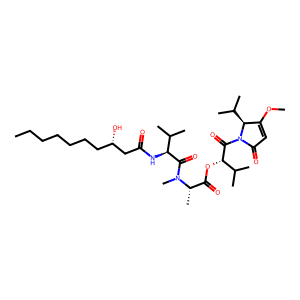

In [ ]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img

In [ ]:
# s2 = "CCCCCCC(O)CC(=O)NC1CCOC1=O"
# s2_FP = fp_loader.build_mfp_for_new_SMILES(s2)
# s2_FP.nonzero().sum(), Kavaratamide_A_FP.nonzero().sum()

In [36]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)

NameError: name 'rankingset_data' is not defined




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.5123475194)



________retival #1, cosine similarity to prediction: 0.6565765142440796_________________
________retival's   cosine similarity to ground truth:  0.44095858931541443
SMILES: COC(=O)C1CCCC1NC(C)=O
Name ['136315-78-1']


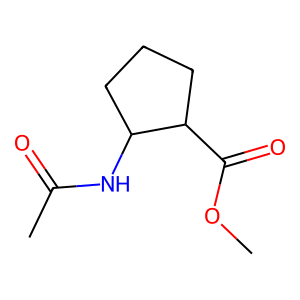

________retival #2, cosine similarity to prediction: 0.6319304704666138_________________
________retival's   cosine similarity to ground truth:  0.4536323547363281
SMILES: CCCC(CCC(C)C1OC(=O)C(C)NC(=O)C(C(C)CCO)N(C)C(=O)C2(C)CN(O2)C(=O)C(C)NC(=O)C1(C)C)OC
Name "(3~{S},7~{S},10~{S},13~{S},16~{S})-13-[(1~{S})-3-hydroxy-1-methyl-propyl]-7-[(1~{R},4~{S})-4-methoxy-1-methyl-heptyl]-3,6,6,10,14,16-hexamethyl-8,17-dioxa-1,4,11,14-tetrazabicyclo[14.1.1]octadecane-2,5,9,12,15-pentone"


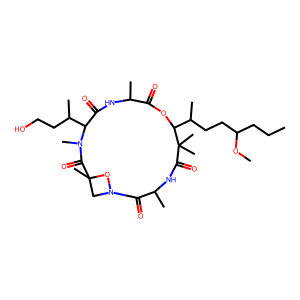

________retival #3, cosine similarity to prediction: 0.6319304704666138_________________
________retival's   cosine similarity to ground truth:  0.47425201535224915
SMILES: CCCC(O)CCC(C)C1OC(=O)C(C)NC(=O)C(C(C)CCO)N(C)C(=O)C2(C)CN(O2)C(=O)C(C)NC(=O)C1(C)C
Name halipeptin B


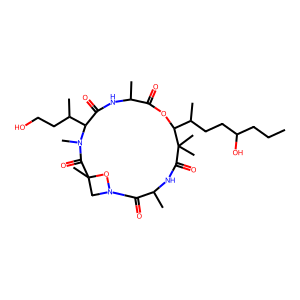

(['COC(=O)C1CCCC1NC(C)=O',
  'CCCC(CCC(C)C1OC(=O)C(C)NC(=O)C(C(C)CCO)N(C)C(=O)C2(C)CN(O2)C(=O)C(C)NC(=O)C1(C)C)OC',
  'CCCC(O)CCC(C)C1OC(=O)C(C)NC(=O)C(C(C)CCO)N(C)C(=O)C2(C)CN(O2)C(=O)C(C)NC(=O)C1(C)C'],
 [['136315-78-1'],
  '"(3~{S},7~{S},10~{S},13~{S},16~{S})-13-[(1~{S})-3-hydroxy-1-methyl-propyl]-7-[(1~{R},4~{S})-4-methoxy-1-methyl-heptyl]-3,6,6,10,14,16-hexamethyl-8,17-dioxa-1,4,11,14-tetrazabicyclo[14.1.1]octadecane-2,5,9,12,15-pentone"',
  'halipeptin B'])

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "MFP_Specific_Radius", filter_by_MW="from_input",
                #    weight_pred = torch.tensor(-fp_loader.total_entropy_of_all_bits).to("cuda").float()
                )
                   

In [ ]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model_DB_specific_FP(model_type)
        max_radius = fp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

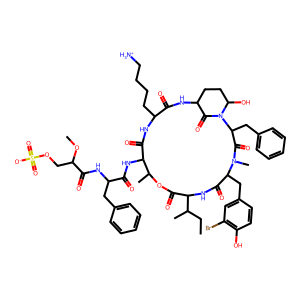

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [ ]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

retival #1, cosine similarity between retrieval and ground truth: 0.80133455991745_____________________________
retrived FP [0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0, 0.0980580672621727, 0.0980580672621727, 0.0, 0.0980580672621727, 0.0980580672621727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0980580672621727, 0.0980580672621727, 0.0980580672621727, 0.0, 0.0980580672621727, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0980580672621727, 0.0980580672621727, 0.0, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0980580672621727, 0.0, 0.0, 0.0, 0.0, 0.098

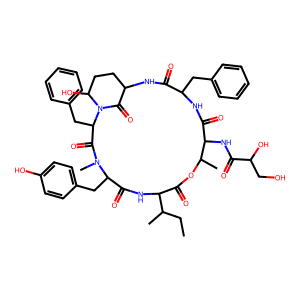

retival #2, cosine similarity between retrieval and ground truth: 0.7877359986305237_____________________________
retrived FP [0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.0, 0.09534625709056854, 0.0, 0.09534625709056854, 0.09534625709056854, 0.0, 0.09534625709056854, 0.09534625709056854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09534625709056854, 0.09534625709056854, 0.09534625709056854, 0.0, 0.09534625709056854, 0.0, 0.09534625709056854, 0.0, 0.0, 0.09534625709056854, 0.09534625709056854, 0.0, 0.0, 0.09534625709056854, 0.0, 0.0, 0.0, 0.0, 0.09534625709056854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09534625709056854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09534625709056854, 0.0, 0.0, 0.09534625709056854, 0.0, 0.

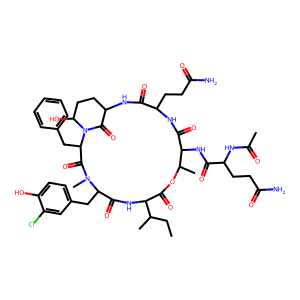

In [ ]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.4715662599)



________retival #1, cosine similarity to prediction: 0.6009684801101685_________________
________retival's   cosine similarity to ground truth:  0.4220811724662781
SMILES: CC(C)CC1C(=O)OC(Cc2ccccc2)C(=O)N(C)C(CC(C)C)C(=O)OC(C)C(=O)N(C)C(CC(C)C)C(=O)OC(Cc2ccccc2)C(=O)N(C)C(CC(C)C)C(=O)OC(C)C(=O)N1C
Name "6,18-dibenzyl-3,9,15,21-tetraisobutyl-4,10,12,16,22,24-hexamethyl-1,7,13,19-tetraoxa-4,10,16,22-tetrazacyclotetracosane-2,5,8,11,14,17,20,23-octone"


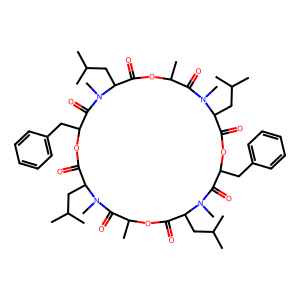

________retival #2, cosine similarity to prediction: 0.5935838222503662_________________
________retival's   cosine similarity to ground truth:  0.3600115478038788
SMILES: COC(=O)C1CC(C)N1C(=O)C(C(C)C)N(O)C(=O)C(CC(C)C)NC(=O)C1CC(OC(C)=O)C(C)N1C(=O)C(CC(C)C)NC(=O)C(NC(=O)C(O)=Cc1cc(Cl)c(OC)c(Cl)c1)C(C)O
Name Bonnevillamide A


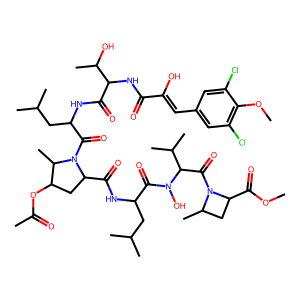

________retival #3, cosine similarity to prediction: 0.5861219763755798_________________
________retival's   cosine similarity to ground truth:  0.3896186053752899
SMILES: CCC(C)C1C(=O)N(C)C(C(C)CC)C(=O)NCC(=O)N(C)C(C(C)C)C(=O)NC(Cc2ccc(OC)cc2)C(=O)OC(C(C)C)C(=O)N2CCCCC2C(=O)N(C)C(C(C)C)C(=O)NC(CC(C)C)C(=O)N(C)C(CC(=O)O)C(=O)N1C
Name Clavariopsin I


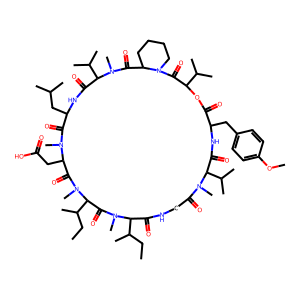

(['CC(C)CC1C(=O)OC(Cc2ccccc2)C(=O)N(C)C(CC(C)C)C(=O)OC(C)C(=O)N(C)C(CC(C)C)C(=O)OC(Cc2ccccc2)C(=O)N(C)C(CC(C)C)C(=O)OC(C)C(=O)N1C',
  'COC(=O)C1CC(C)N1C(=O)C(C(C)C)N(O)C(=O)C(CC(C)C)NC(=O)C1CC(OC(C)=O)C(C)N1C(=O)C(CC(C)C)NC(=O)C(NC(=O)C(O)=Cc1cc(Cl)c(OC)c(Cl)c1)C(C)O',
  'CCC(C)C1C(=O)N(C)C(C(C)CC)C(=O)NCC(=O)N(C)C(C(C)C)C(=O)NC(Cc2ccc(OC)cc2)C(=O)OC(C(C)C)C(=O)N2CCCCC2C(=O)N(C)C(C(C)C)C(=O)NC(CC(C)C)C(=O)N(C)C(CC(=O)O)C(=O)N1C'],
 ['"6,18-dibenzyl-3,9,15,21-tetraisobutyl-4,10,12,16,22,24-hexamethyl-1,7,13,19-tetraoxa-4,10,16,22-tetrazacyclotetracosane-2,5,8,11,14,17,20,23-octone"',
  'Bonnevillamide A',
  'Clavariopsin I'])

In [ ]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




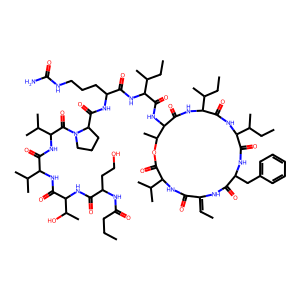

(['Oligopeptides'], False)

In [ ]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

retival #1, cosine similarity between retrieval and ground truth: 0.8716546893119812_____________________________
retrived FP [0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.0, 0.0, 0.08770579844713211, 0.08770579844713211, 0.08770579844713211, 0.0, 0.08770579844713211, 0.0, 0.08770579844713211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08770579844713211, 0.08770579844713211, 0.0, 0.08770579844713211, 0.0, 0.08770579844713211, 0.0, 0.0, 0.08770579844713211, 0.08770579844713211, 0.0, 0.0, 0.08770579844713211, 0.0, 0.0, 0.0, 0.0, 0.08770579844713211, 0.08770579844713211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08770579844713211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08770579844713211, 0.0, 0.0, 0.08770579844713211, 0.0, 0.

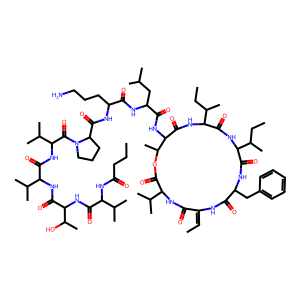

In [ ]:
newCompoundB_FP = fp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)

In [ ]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.3507584631)





([], [])




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7694178224)



________retival #1, cosine similarity to prediction: 0.8492103219032288_________________
________retival's   cosine similarity to ground truth:  0.8705949783325195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrol

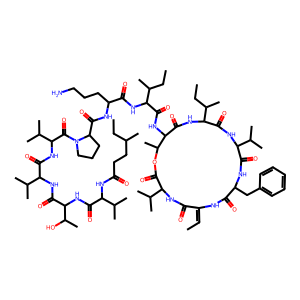

________retival #2, cosine similarity to prediction: 0.8491761088371277_________________
________retival's   cosine similarity to ground truth:  0.8705949783325195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


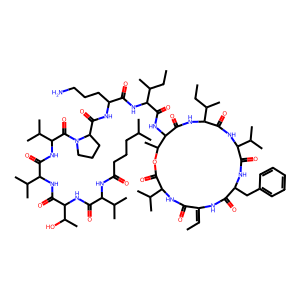

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"',
  '9898671'])

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [ ]:

fp_loader.total_entropy_of_all_bits, fp_loader.indices_kept

AttributeError: 'DB_Specific_FP_loader' object has no attribute 'total_entropy_of_all_bits'

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [ ]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)